In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/distance/Distance_Matrix.csv
/kaggle/input/biomass-data/biomass.csv
/kaggle/input/biomass/Biomass_History.csv


In [3]:
!pip install keras-rl2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 3.9 MB/s eta 0:00:00


In [5]:
import plotly.express as px
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredLogarithmicError,MeanSquaredError,MeanAbsoluteError
from matplotlib import pyplot as plt
from shapely.geometry import Point, MultiPoint
import rtree
from sklearn.neighbors import NearestNeighbors
from gym import Env
from gym.spaces import Box, MultiDiscrete, Dict,Discrete
from shapely.ops import nearest_points
import geopandas as gpd
import seaborn as sns
import random
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
%matplotlib inline

In [7]:
biomass = pd.read_csv("/kaggle/input/biomass/Biomass_History.csv")
distance = pd.read_csv("/kaggle/input/distance/Distance_Matrix.csv")
# creating point objects, will be useful later on 
points = []
for i, row in biomass.iterrows():
    points.append((float(row['Longitude']),float(row["Latitude"])) )

biomass["Geometries"] = points
biomass["Type"] = "Biomass prod.plants"
print(biomass.head())


   Index  Latitude  Longitude       2010       2011       2012       2013  \
0      0  24.66818   71.33144   8.475744   8.868568   9.202181   6.023070   
1      1  24.66818   71.41106  24.029778  28.551348  25.866415  21.634459   
2      2  24.66818   71.49069  44.831635  66.111168  56.982258  53.003735   
3      3  24.66818   71.57031  59.974419  80.821304  78.956543  63.160561   
4      4  24.66818   71.64994  14.653370  19.327524  21.928144  17.899586   

        2014       2015       2016        2017            Geometries  \
0  10.788374   6.647325   7.387925    5.180296  (71.33144, 24.66818)   
1  34.419411  27.361908  40.431847   42.126945  (71.41106, 24.66818)   
2  70.917908  42.517117  59.181629   73.203232  (71.49069, 24.66818)   
3  93.513924  70.203171  74.536720  101.067352  (71.57031, 24.66818)   
4  19.534035  19.165791  16.531315   26.086885  (71.64994, 24.66818)   

                  Type  
0  Biomass prod.plants  
1  Biomass prod.plants  
2  Biomass prod.plants  
3  B

/tmp/ipykernel_32/1850315607.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(biomass.corr(), annot=True)


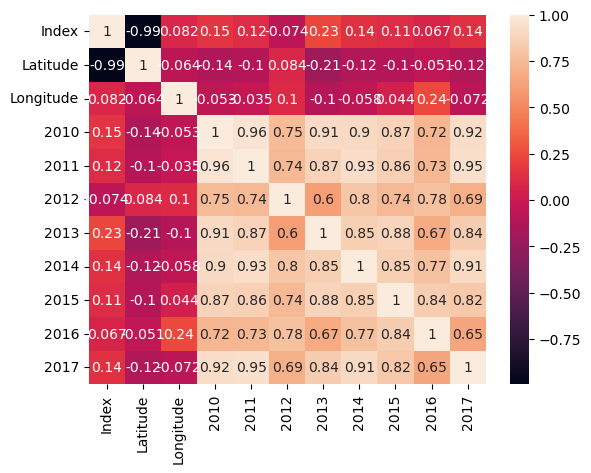

In [6]:
sns.heatmap(biomass.corr(), annot=True)
plt.show()

In [7]:
fig = px.scatter_mapbox(biomass, lat="Latitude", lon="Longitude",hover_data=["Index"],
                        color="2014", zoom=3, height=400)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show(renderer='iframe')

In [6]:
#predictions using neural networks

""" First a little data prep. We need to batch the results from 2010 till 2016, the 2017 
results will serve as the target values for the neural network"""

x = biomass[[str(i+2000) for i in range(10,17)]].values
print(x.shape)
y = biomass["2017"].values
print(y.shape)
scaler = StandardScaler()
x = scaler.fit_transform(x)
X_train,X_test,Y_train,Y_test = train_test_split(x,y, test_size = 0.25, random_state = 32)
print (X_train.shape, X_test.shape)


def build_net_no_dropout(input_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(input_size,activation = 'relu'))
    model.add(tf.keras.layers.Dense(128, activation = "relu"))
    model.add(tf.keras.layers.Dense(32, activation = "relu"))
    model.add(tf.keras.layers.Dense(1, activation = 'relu'))
    return model


def build_net_with_dropout(input_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(input_size,activation = 'relu',kernel_regularizer = tf.keras.regularizers.L1(0.01)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(128, activation = "relu",kernel_regularizer = tf.keras.regularizers.L1(0.01)))
    model.add(tf.keras.layers.Dropout(0.7))
    model.add(tf.keras.layers.Dense(32, activation = "relu",kernel_regularizer = tf.keras.regularizers.L1(0.01)))
    model.add(tf.keras.layers.Dense(1, activation = 'relu'))
    return model

def model_run(model,train_x,val_y, train_y, val_x, num_epochs):
    loss = MeanSquaredLogarithmicError()
    optimizer = "adam"
    model.compile( loss= loss, optimizer = optimizer, metrics = ["msle"])
    #training
    history = model.fit(train_x,train_y, epochs = num_epochs,batch_size= 70, verbose = 1,validation_data = (val_x,val_y))
    return history

def plotter(history,metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric,'val_'+metric])
    plt.show()
    



(2418, 7)
(2418,)
(1813, 7) (605, 7)


Train on 1813 samples, validate on 605 samples
Epoch 1/30
1813/1813 [==============================] - 2s 1ms/sample - loss: 16.8613 - msle: 16.8613 - val_loss: 13.1201 - val_msle: 13.1201
Epoch 2/30
1813/1813 [==============================] - 0s 35us/sample - loss: 11.1452 - msle: 11.1452 - val_loss: 8.3925 - val_msle: 8.3925
Epoch 3/30
1813/1813 [==============================] - 0s 37us/sample - loss: 7.1645 - msle: 7.1645 - val_loss: 5.4574 - val_msle: 5.4574
Epoch 4/30
  70/1813 [>.............................] - ETA: 0s - loss: 5.8890 - msle: 5.8890

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2335: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



1813/1813 [==============================] - 0s 35us/sample - loss: 4.8681 - msle: 4.8681 - val_loss: 3.8849 - val_msle: 3.8849
Epoch 5/30
1813/1813 [==============================] - 0s 37us/sample - loss: 3.6112 - msle: 3.6112 - val_loss: 3.0223 - val_msle: 3.0223
Epoch 6/30
1813/1813 [==============================] - 0s 38us/sample - loss: 2.9048 - msle: 2.9048 - val_loss: 2.4985 - val_msle: 2.4985
Epoch 7/30
1813/1813 [==============================] - 0s 35us/sample - loss: 2.4459 - msle: 2.4459 - val_loss: 2.1424 - val_msle: 2.1424
Epoch 8/30
1813/1813 [==============================] - 0s 38us/sample - loss: 2.1170 - msle: 2.1170 - val_loss: 1.8648 - val_msle: 1.8648
Epoch 9/30
1813/1813 [==============================] - 0s 36us/sample - loss: 1.8508 - msle: 1.8508 - val_loss: 1.6463 - val_msle: 1.6463
Epoch 10/30
1813/1813 [==============================] - 0s 35us/sample - loss: 1.6602 - msle: 1.6602 - val_loss: 1.4956 - val_msle: 1.4956
Epoch 11/30
1813/1813 [==============

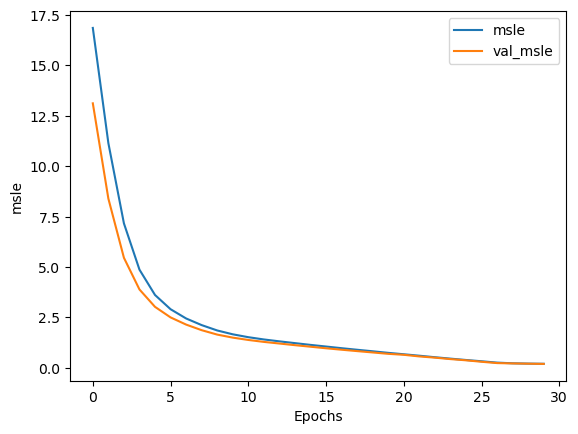

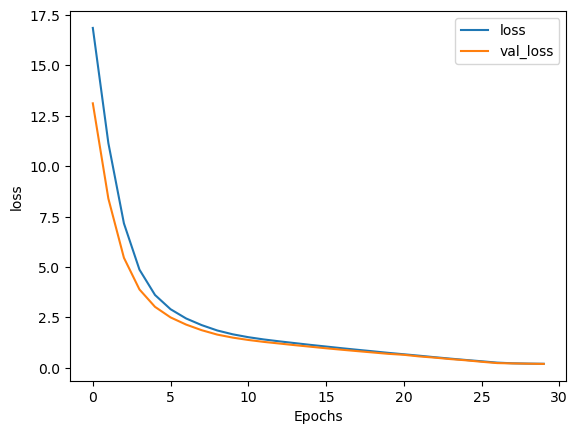

In [9]:
#putting it all together

ann_without = build_net_no_dropout(X_train.shape[1])
hist_ann_without = model_run(ann_without,X_train,Y_test,Y_train,X_test,30)
plotter(hist_ann_without, "msle")
plotter(hist_ann_without, "loss")


Train on 1813 samples, validate on 605 samples
Epoch 1/40
1813/1813 [==============================] - 0s 188us/sample - loss: 22.1183 - msle: 17.2121 - val_loss: 18.4578 - val_msle: 13.7019
Epoch 2/40
1813/1813 [==============================] - 0s 80us/sample - loss: 16.5093 - msle: 11.8828 - val_loss: 13.4352 - val_msle: 8.9483
Epoch 3/40
1813/1813 [==============================] - 0s 79us/sample - loss: 12.5559 - msle: 8.1930 - val_loss: 10.3268 - val_msle: 6.1003
Epoch 4/40
1813/1813 [==============================] - 0s 62us/sample - loss: 10.1739 - msle: 6.0731 - val_loss: 8.4805 - val_msle: 4.5149
Epoch 5/40
1813/1813 [==============================] - 0s 71us/sample - loss: 8.5419 - msle: 4.6987 - val_loss: 7.3125 - val_msle: 3.6029
Epoch 6/40
1813/1813 [==============================] - 0s 77us/sample - loss: 7.5479 - msle: 3.9543 - val_loss: 6.5166 - val_msle: 3.0425
Epoch 7/40
1813/1813 [==============================] - 0s 79us/sample - loss: 6.6907 - msle: 3.3136 - val_l

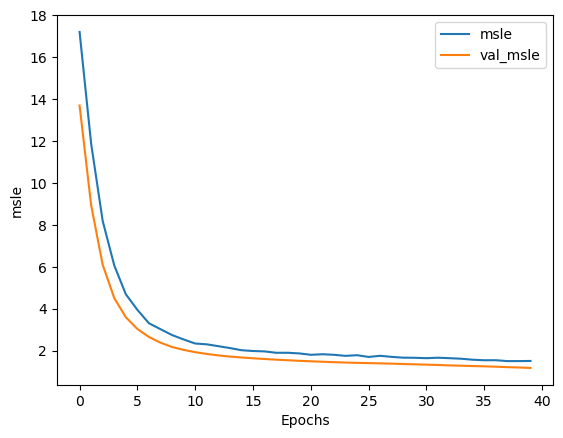

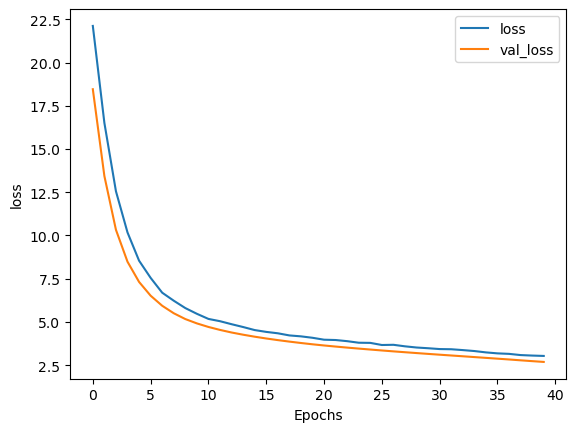

In [9]:
ann_with = build_net_with_dropout(X_train.shape[1])
hist_ann_with = model_run(ann_with,X_train,Y_test,Y_train,X_test,40)
plotter(hist_ann_with, "msle")
plotter(hist_ann_with, "loss")

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



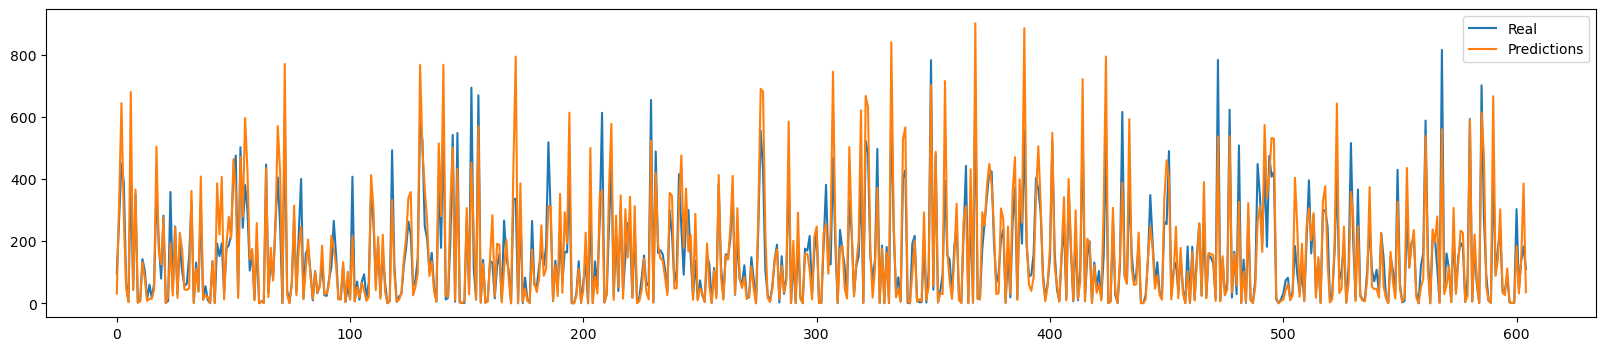

In [10]:

Predictions = ann_without.predict(X_test)
Real = Y_test
dft = pd.DataFrame({"real_2017":list(Y_test),"Prediction_2017":list(Predictions)})
plt.figure(figsize =(20,4))
plt.plot(dft["real_2017"])
plt.plot(dft["Prediction_2017"])
plt.legend(["Real", "Predictions"])
plt.show()

In [12]:

#(number,name, k, cap,pointlist,depots,pointx=[],index=-1,refinery=False, allx=points.copy()
points = points 
depots,pointx = make_components(25,"depot_location",80, 20000,points)
dep_points = [q.point for q in depots]
dep_index =[points.index(q)for q in dep_points]
refineries,refpointx = make_refinery(5,"refinery_location",5, 100000,pointx,dep_index)
usage(points,depots,refineries)    

done
2334
current avail dept: [1348, 1075, 2060, 591, 558, 312, 945, 1269, 1259, 2008, 1195, 766, 2223, 294, 1883, 1275, 1866, 481, 2083, 696, 820, 2361, 1988, 1339, 1428]
518
current avail dept: [1348, 1075, 2060, 591, 558, 312, 945, 2008, 1195, 766, 2223, 294, 1883, 1275, 481, 2083, 696, 820, 2361, 1428]
574
current avail dept: [1348, 1075, 2060, 591, 558, 312, 945, 2008, 766, 2223, 1883, 696, 820, 2361, 1428]
1802
current avail dept: [1075, 2060, 591, 2008, 766, 2223, 1883, 696, 2361, 1428]
2022
current avail dept: [2060, 591, 2008, 766, 696]
done
[12126.087004978, 9115.489396803, 3152.875355675, 2609.811351983, 14652.370795125, 9203.404325566, 15538.31273021, 19911.927551400004, 19636.744964499998, 8473.937361819, 15254.580325865998, 3944.469729851, 10389.469554672, 10010.311524936002, 19895.6393737, 19853.2834014, 19809.327362099997, 7987.405263376, 17586.335103157002, 12815.210928262, 15082.89920815, 3608.5620666019995, 14965.235512961, 19837.777648799998, 8669.523941748]
[1348, 

80.94465304560686

In [9]:
# each additional component in the waste to energy supply chain will be represented 

class Component():
    def __init__(self, index, name, num, cap, points,k, pointx,refinery, data=biomass.copy(),distance = distance.copy(),spare =points.copy(),sources=None):
        self.name = name
        self.index = index
        self.num = num       
        self.capacity = cap
        self.is_ref = refinery
        self.tree = rtree.index.Rtree()
        self.point = spare[index]
        self.depot_left = sources
            
    
        if refinery==True and sources!=  None:
            for i,a in enumerate(sources):# sources should be index numbers
                p=spare[a]
                self.tree.insert(i,p+p,p)
                
        else:
            for i,p in enumerate(pointx):
                self.tree.insert(i,p+p,p)
            
       
            
        
        # k nearest point
        self.sources= list(self.tree.nearest(self.point, k+1,objects='raw' ))
        #print(len(self.sources))
        self.sources_index = []
        if self.is_ref ==False:
            for i in self.sources:
                self.sources_index.append(spare.index(i))
                pointx.remove(i)
        else:
            pointx.remove(spare[self.index]) 
            for i in self.sources:
                self.sources_index.append(spare.index(i))
               
            
               
        self.sources= self.sources[1:]
        self.sources_index= self.sources_index[1:]
        #print("Original number of sources {}".format(len(self.sources)))
        
        #this part calculates the total output of the sources
        if self.is_ref==False:
            sources_output = data["2017"][self.sources_index].sum()
        
            self.under_util = 0
            if sources_output>self.capacity and refinery == False:
                while True:
                    lee = data["2017"][self.sources_index].values
                    minx = np.argmin(lee, axis = 0)
                    pointx.append(self.sources[minx])
                    self.sources.pop(minx)
                    self.sources_index.pop(minx)
                    sources_output = data["2017"][self.sources_index].sum()
                
                    if sources_output<=self.capacity:
                        self.under_util = self.capacity-sources_output
                        break
                    else:
                        continue
                    
            self.sources_output = sources_output 
        self.total_dist = 0
        for i in self.sources_index:
            self.total_dist+=distance.iloc[i,self.index]
        self.pointx = pointx[:]
        #print("final number of sources {}".format(len(self.sources)))
        
    def prevent_duplicates(self):
        if self.is_ref ==True:
            depot_left = self.depot_left
            for iw in self.sources_index:
                depot_left.remove(iw)
            del(self.depot_left)
            return self.pointx,depot_left
        else:
            return self.pointx
            
    def add(self,df):
        q= int(self.index)
        df.Type[q] = str(self.name)
        return df
    def output(self):
        return self.sources_output
    def cost(self):
        return self.total_dist,self.under_util
    
            
        
        

def make_refinery(number,name, k, cap,pointlist,depots,pointx=[],index=-1,refinery=True, allx=points.copy()):
    
    refineries = [] 
    if index==-1:        
        listr = [] 
        pointx = pointlist[:]
        for i in range(number):
            index = allx.index(random.choice(pointx))
            print(index)
            if index not in listr :
                print("current avail dept: {}".format(depots))
                comp = Component(index,name,i,cap,pointlist,k,pointx,refinery = refinery,sources=depots)
                pointx,depots= comp.prevent_duplicates()
                refineries.append(comp)
                listr.append(index)
                
            else:
                i = i-1
                continue
    print("done")
    return refineries,depots   

def make_components(number,name, k, cap,pointlist,pointx=[],index=-1,refinery=False):
    components = [] 
    if 1==1:        
        listr = [] 
        pointx = pointlist.copy()
        for i in range(number):
            index = random.randint(0,2417)
            if index not in listr :
                
                
                comp = Component(index,name,i,cap,pointlist,k,pointx,refinery = refinery)
                pointx= comp.prevent_duplicates()
                components.append(comp)
                listr.append(index)
                
            else:
                i = i-1
                continue
    print("done")
    return components,pointx
        
    
    
     
    
    


In [ ]:
q= np.array([1,4])
q.shape


In [10]:
#creating a custom environment with gym

class Environment(Env):
    def __init__(self,num_dep,num_refinery, points = points):
        a = 0.001
        b = 1
        c = 1
        self.k = 80
        self.points = points 
        self.num_dep = num_dep
        self.refinery_cap = 100000
        self.num_refinery = num_refinery
        self.dep_cap = 20000
        #new
        self.depots,self.pointx = make_components(25,"depot_location",self.k, self.dep_cap,points)
        self.dep_points = [q.point for q in self.depots]
        self.dep_index =[points.index(q)for q in self.dep_points]
        self.refineries,self.refpointx = make_refinery(5,"refinery_location",5, 100000,pointx,self.dep_index)
        usage(points,depots,refineries)    
        #new
        self.ref_points = [q.point for q in self.refineries]
        self.transport = 0
        self.underutil = 0
        self.ndim=(self.num_dep+self.num_refinery,2)
        self.observation_space = Box(high= np.inf,low = -np.inf,shape = (2,))
        self.action_space =Discrete(np.prod(self.ndim))
        for i in self.depots:
            tr,un = i.cost()
            self.transport+=tr
            self.underutil+=un
        for i in self.refineries:
            tr,un = i.cost()
            self.transport+=tr
            self.underutil+=un
        self.state = (a*self.transport)+(c*self.underutil)
        self.episode_len = 100
        self.use = self.usage()
        self.previous_score = []
        self.reinitialize= {"depots":self.depots,
                            "refinery":self.refineries, 
                            "refinery_points":self.ref_points,
                            "depot_points" :self.dep_points,
                            "deppointx":self.pointx,
                            'refpoints':self.refpointx,
                            "usage" : self.use
                           }
        print("utilizing {} percent of all available output".format(self.use))
        
        
    def usage(self):
        
        all_dep_output = [q.sources_output for q in self.depots]
        print(all_dep_output)
        all_dep_indexes = [q.index for q in self.depots]
        all_ref_sources = [q.sources_index for q in self.refineries]
        all_ref_sources_flat=[]
        for e in all_ref_sources:
            for q in e:
                all_ref_sources_flat.append(q)
       
                                   
        
        print("refinery sources \n")
        
    
    
        
        total_usage = 0
        for i in all_ref_sources_flat:
            if i in all_dep_indexes:
                pla = all_dep_indexes.index(i)
                total_usage= total_usage+all_dep_output[pla]
                print(total_usage)
        perc = 100*(total_usage/(biomass["2017"].sum()))
        return perc
         

        return perc
            
        
        
            
        
        
    def observe(self):
        return np.array([self.state,self.use])
    
    def reset(self):
        self.reinitialize["depots"] = self.depots
        self.reinitialize["refinery"] = self.refineries 
        self.reinitialize["refinery_points"] =self.ref_points
        self.reinitialize["depot_points"] =self.dep_points
        self.reinitialize["deppointx"] = self.pointx
        self.reinitialize['refpoints'] = self.refpointx
        self.reinitialize["usage"] : self.usage
        self.episode_len = 100
        self.previous_score = []
        self.state = self.recalc()
        obs = self.observe()
        return obs
        
    def recalc (self):
        a = 0.001
        b = 1
        c = 1
        self.transport = 0
        self.underutil = 0
        for i in self.depots:
            tr,un = i.cost()
            self.transport+=tr
            self.underutil+=un
        for i in self.refineries:
            tr,un = i.cost()
            self.transport+=tr
            self.underutil+=un
        var = (a*self.transport)+(c*self.underutil)
        return var
        
    def close(self):
        pass
        
    def step(self, action):
        reward = 0
        mapping = tuple(np.ndindex(self.ndim))
        action = mapping[action]
        if action[0]>=(self.num_dep) and self.episode_len>0:
            # if the agent picks from [0, self.num_dep] that indicates a depot, else its a refinery
            # in this case it is a refinery that has been selected
            self.episode_len -= 1 
              #selcting one the final motion [left:0,right:1]                
            rp = self.ref_points[action[0]-self.num_dep]
            indx = self.points.index(rp)
            if action[1] == 0: #left
                if indx-10>=0:
                    for i in self.refineries[action[0]-self.num_dep].sources:
                        self.refpointx.append(i)
                    self.pointx.append(self.refineries[action[0]-self.num_dep].point)   
                        
                    ref_new =Component(indx-10,"refinery_location",indx-10,100000,self.dep_points,4,self.refpointx,refinery = True)
                    self.refpointx = ref_new.prevent_duplicates()
                    self.refineries[action[0]-self.num_dep] = ref_new
                    self.ref_points[action[0]-self.num_dep] = ref_new.point 
                    
                    self.state = self.recalc() 
                else:
                    reward -= 20
                    
            elif action[1] == 1:# right
                if indx+10<=2417:
                    for i in self.refineries[action[0]-self.num_dep].sources:
                        self.refpointx.append(i)
                    self.pointx.append(self.refineries[action[0]-self.num_dep].point)
                    ref_new=Component(indx+10,"refinery_location",indx+10,100000,self.dep_points,4,self.refpointx,refinery = True)                     
                    self.refpointx = ref_new.prevent_duplicates()
                    print(type(ref_new))
                    self.refineries[action[0]-self.num_dep] =ref_new
                   
                    self.ref_points[action[0]-self.num_dep] =ref_new.point 
                    self.state = self.recalc()
                else:
                    reward -= 20      
            
        elif action[0]<(self.num_dep) and self.episode_len>0:                               #in this case the agent selects a depot
            self.episode_len -= 1 
              #selcting one the final motion [left,right]
            dp = self.dep_points[action[0]]
            indx = self.points.index(dp)
            if action[1] == 0: #left
                
                
                if indx-10>=0:
                    for i in self.depots[action[0]].sources:
                        self.pointx.append(i)
                    self.pointx.append(self.depots[action[0]].point)
                    # this code block is necessary, so we can remove depos from attached refineries
                    qwe = [q.sources for q in self.refineries]
                    ins = 0
                    for qw in qwe:
                        if self.depots[action[0]].point in qw:
                            ins = qwe.index(qw)
                            pox = que[qw].index(self.depots[action[0]].point)
                            break
                        else:
                            continue
                    
                    
                    
                    dep_new= Component(indx-10,"depot_location",indx-10,20000,self.points,self.k,self.pointx,refinery = False)
                    self.pointx=dep_new.prevent_duplicates() 
                    
                    self.depots[action[0]] =dep_new
                    self.dep_points[action[0]] =dep_new.point
                    
                    self.refineries[ins].sources[pox] = dep_new.point
                    self.refineries[ins].sources_index [pox]=dep_new.index
                
                    self.state = self.recalc() 
                else:
                    reward -= 20
                    
            elif action[1] == 1:# right
                if indx+10<=2417:
                    for i in self.depots[action[0]].sources:
                        self.pointx.append(i)
                    self.pointx.append(self.depots[action[0]].point)
                    # this code block is necessary, so we can remove depos from attached refineries
                    qwe = [q.sources for q in self.refineries]
                    ins =0
                    pox = 0
                    for qw in qwe:
                        if self.depots[action[0]].point in qw:
                            ins = qwe.index(qw)
                            pox = que[qw].index(self.depots[action[0]].point)
                            break
                        else:
                            continue
                    
                    
                    dep_new = Component(indx+10,"depot_location",indx+10,20000,self.points,self.k,self.pointx,refinery = False)                    
                    self.pointx=dep_new.prevent_duplicates() 
                    self.depots[action[0]] =dep_new
                    self.dep_points[action[0]] =dep_new.point
                    self.refineries[ins].sources[pox] = dep_new.point
                    self.refineries[ins].sources_index [pox]=dep_new.index
                    
                    
                    
                    
                    self.state = self.recalc() 
                else:
                    reward -= 20
                    
                    
                
        
        # Calculating the reward
        if len(self.previous_score)>0:
            reward += (20*(self.previous_score[-1]-self.state))/self.previous_score[-1]
            self.previous_score.append(self.state)
 
  
        elif len(self.previous_score)==0:
            self.previous_score.append(self.state) 
            
        # additional rewards
        self.use = self.usage()
        if self.use<=80:
            reward+= 9
        else:
            reward-=2
            
        
        # Checking if episode is done
        if self.episode_len <= 0: 
            done = True
        else:
            done = False
        
        # Setting the placeholder for info
       
        info = {'usage':self.use}
        
        # Returning the step information
        return self.observe(), reward, done,info

In [ ]:
Enviro = Environment(23,5)
state = Enviro.observation_space.shape
actions = Enviro.action_space.n

In [9]:
def usage(points,depots,refineries):
         
        all_dep_output = [q.sources_output for q in depots]
        print(all_dep_output)
        all_dep_indexes = [q.index for q in depots]
        all_ref_sources = [q.sources_index for q in refineries]
        all_ref_sources_flat=[]
        for e in all_ref_sources:
            for q in e:
                all_ref_sources_flat.append(q)
       
                                   
        print(all_dep_indexes)
        print("refinery sources \n")
        
        print(all_ref_sources_flat)
    
        
        total_usage = 0
        for i in all_ref_sources_flat:
            if i in all_dep_indexes:
                pla = all_dep_indexes.index(i)
                total_usage= total_usage+all_dep_output[pla]
                print(total_usage)
        perc = 100*(total_usage/(biomass["2017"].sum()))
        return perc

[2122, 543, 1826, 1786, 643, 1705, 530, 148, 566, 100, 2311, 248, 2366, 201, 1926, 1129, 771, 1480, 2056, 2178, 1101, 1898, 174, 2248, 1596]
refinery sources 

[2056, 1826, 1480, 2178, 1926, 1705, 543, 1596, 2122, 530, 174, 148, 566, 100, 248, 201, 1786, 1898, 1101, 2248, 1129, 2366, 2311, 643]


0.0

In [ ]:
[q.index for q in Enviro.refineries]

In [ ]:
 [q.index for q in Enviro.depots]

In [ ]:
 [q.sources_index for q in Enviro.refineries]

In [ ]:
# model
model = tf.keras.models.Sequential()    
model.add(tf.keras.layers.Dense(32, activation='relu', input_shape =(1,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(actions, activation='linear'))


In [ ]:
Enviro.usage

In [ ]:

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=100, target_model_update=1e-2)
    return dqn

In [ ]:
[points.index(i) for i in Enviro.dep_points]

In [ ]:
benv = Environment(25,5)

In [ ]:
Agent = build_agent(model, actions)
Agent.compile(tf.keras.optimizers.legacy.Adam(learning_rate=1e-2), metrics=['mae'])
Agent.fit(Enviro , nb_steps=1000, visualize=False, verbose=1)